In [0]:
import numpy as np
from google.colab import drive

from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import math

%matplotlib inline
plt.rcParams["figure.figsize"] = 12.8, 9.6

In [73]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [222]:
!ls "/content/gdrive/My Drive/Colab Notebooks/orientation"

box_0_output.npy


In [0]:
def load_point_cloud():
  df = np.load("/content/gdrive/My Drive/Colab Notebooks/orientation/box_2_output.npy")
  return df.T

In [483]:
points = load_point_cloud()
print(points)

[[3.78000000e+02 3.78000000e+02 3.78000000e+02 ... 4.94000000e+02
  4.94000000e+02 4.94000000e+02]
 [1.14200000e+03 1.14300000e+03 1.14400000e+03 ... 7.80000000e+02
  7.81000000e+02 7.82000000e+02]
 [2.73000002e-01 2.73000002e-01 2.72000015e-01 ... 2.36000016e-01
  2.36000016e-01 2.36000016e-01]]


In [0]:
def filter_input_data_for_outliers(points):
  points[2] = points[2]*200
  std_dev = np.std(points[2])
  mean = np.mean(points[2])

  print("standard deviation = ", std_dev)
  print("mean = ", mean)
  print("array shape = ", points.shape)

  filtered_array = np.array([])
  for index in range(len(points[2])):
    if points[2][index] > std_dev:
      filtered_array = np.append(filtered_array, points[:, index], axis=0)
  
  # print("flat array length = ", len(filtered_array)/3)
  filtered_array = np.reshape(filtered_array, (int(len(filtered_array)/3), 3))
  print("new array shape = ", filtered_array.T.shape)
  return filtered_array.T

In [509]:
filtered_points = filter_input_data_for_outliers(points)
print(filtered_points)

standard deviation =  336.16642221642957
mean =  873.5323387650332
array shape =  (3, 17618)
new array shape =  (3, 15394)
[[ 378.          378.          378.         ...  494.
   494.          494.        ]
 [1142.         1143.         1144.         ...  780.
   781.          782.        ]
 [1092.00000763 1092.00000763 1088.00005913 ...  944.00006533
   944.00006533  944.00006533]]


In [0]:
def distance(X,p):
    plane = p[0:3]
    distance = (plane*X.T).sum(axis=1) - p[3]
    return distance / np.linalg.norm(plane)

def residuals(params, signal, X):
    return distance(X, params)

In [0]:
def get_initial_plane_coefficient():
    """ 
    plane equation is aX + bY + cZ = d
    plane_coeff = [a, b, c, d]
    """
    plane_coeff = [0.506645455682, -0.185724560275, -1.43998120646, 1.37626378129]
    
    return plane_coeff

In [0]:
plane_coeff = get_initial_plane_coefficient()

In [0]:
# solution = leastsq(residuals, plane_coeff, args=(None, points))[0]
solution = leastsq(residuals, plane_coeff, args=(None, filtered_points))[0]

In [514]:
print("a = ", solution[0], "b = ", solution[1], "c = ", solution[2], "d = ", solution[3])

a =  -77.53990539105573 b =  24.835922398171107 c =  -87.15293794742365 d =  -98107.47342036263


In [515]:
print("old offset = ", (distance(points, plane_coeff)**2).sum())
print("new offset =  ", (distance(points, solution)**2).sum())

old offset =  12671500522.455225
new offset =   1304541092.1315725


In [0]:
def get_plane_point_cloud(a, b, c, d):
    
    if a != 0:
        x = np.linspace(0,500,10)
    else:
        x = np.linspace(0,0,10)
        
    if b != 0:
        y = np.linspace(0,500,10)
    else:
        y = np.linspace(0,0,10)
    
    
    
    if c != 0:
        X,Y = np.meshgrid(x,y)
        Z = (d - (a*X + b*Y))/c
    else:
        z = np.linspace(0,0,10)
        X,Z = np.meshgrid(x, z)
        Y = (d - (a*X + c*Z))/b

    return X, Y, Z

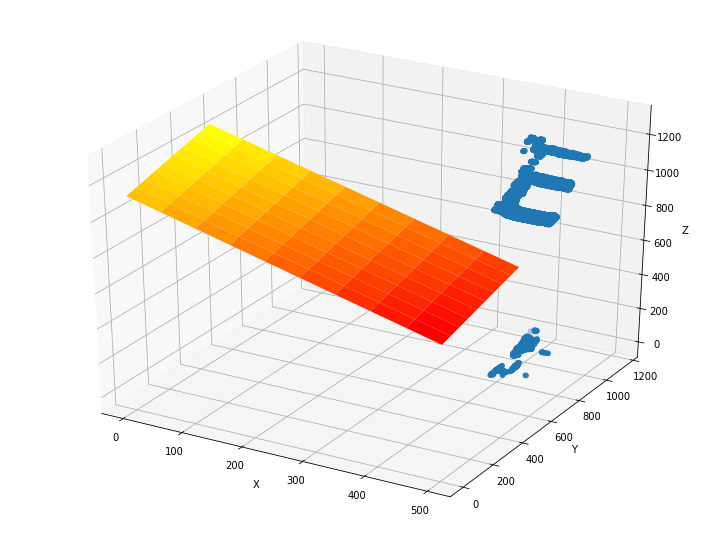

In [517]:
fig = plt.figure()

# ax = plt.axes(projection='3d')
ax = fig.gca(projection='3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# plot point cloud
xs = points[0]
ys = points[1]
zs = points[2]

ax.scatter(xs, ys, zs, linewidth=1)

# # plot inferred plan
X, Y, Z = get_plane_point_cloud(solution[0], solution[1], solution[2], solution[3])
ax.plot_surface(X, Y, Z, alpha=1, cmap='autumn')

# plot reference plan
ref_plane_a = 1
ref_plane_b = 0
ref_plane_c = 1
ref_plane_d = 1

X, Y, Z = get_plane_point_cloud(ref_plane_a, ref_plane_b, ref_plane_c, ref_plane_d)
# ax.plot_surface(X, Y, Z, alpha=0, cmap='winter')

In [0]:
def calculate_angle_between_planes(a1, b1, c1, a2, b2, c2):
    n = abs(a1*a2 + b1*b2 + c1*c2)
    d1 = math.sqrt(a1*a1 + b1*b1 + c1*c1)
    d2 = math.sqrt(a2*a2 + b2*b2 + c2*c2)
    cos_angle = round(n/(d1*d2), 4)
    print("n = ", n, " d1 = ", d1, " d2 = ", d2, "angle in radians = ", cos_angle)
    angle = math.degrees(math.acos(cos_angle))
    return angle

In [507]:
print("Inferred ->  a = ", solution[0], "b = ", solution[1], "c = ", solution[2], "d = ", solution[3])
print("Reference -> a = ", ref_plane_a, "b = ", ref_plane_b, "c = ", ref_plane_c, "d = ", ref_plane_d)

angle = calculate_angle_between_planes(solution[0], solution[1], solution[2], ref_plane_a, ref_plane_b, ref_plane_c)
print("angle between plan is %d degrees"%(angle))

Inferred ->  a =  -0.314785324421422 b =  0.21461966644982317 c =  -134.3725612611618 d =  -613.2645268509899
Reference -> a =  1 b =  0 c =  1 d =  1
n =  134.6873465855832  d1 =  134.3731013681175  d2 =  1.4142135623730951 angle in radians =  0.7088
angle between plan is 44 degrees
